#### Introduction
A good friend of mine is an entrepreneur and investor from abroad who happens to be willing to invest in New York City's hospitality. He asked me for assistance with identifying what kind of restaurant to establish and which neighborhood to pick. 

Undoubtedly, this is not an easy task, given New York City is comprised of five boroughs that geographically make up over 300 square miles. Within this area, 59 community districts define the economic profile of the City. As a result, there are so many unique neighborhoods that contribute to its demographic and cultural diversity.

This project will help to understand my entrepreneur friend in the understanding of the diversity of neighborhoods by leveraging venue data from Foursquare’s Places API and K-means clustering machine learning algorithm. Exploratory Data Analysis will help to discover further about the cultural diversities of NYC's neighborhoods. Also, this project can be used by food vendors that are willing to open a new restaurant. 

#### Data
Following data sources will be used to examine the business problem:
- New York City Dataset.
This New York City Neighborhood Names point file was created as a guide to New York City’s neighborhoods that appear on the web resource, “New York: A City of Neighborhoods.” Link: https://geo.nyu.edu/catalog/nyu_2451_34572

- Foursquare API.
Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. This is the link to Foursquare Venue Category Hierarchy. Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc.


#### Methodology
Install all the packages and download the dependencies.

In [1]:
%pip install geocoder
%pip install geopy
%pip install beautifulsoup4
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

     |████████████████████████████████| 102kB 6.0MB/s ta 0:00:011
     |████████████████████████████████| 92kB 5.4MB/s eta 0:00:01
     |████████████████████████████████| 829kB 9.4MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 122kB 5.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 122kB 1.8MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Download and Explore New York City Dataset
In order to segment the neighborhoods of New York City, a required dataset should contain all the 5 boroughs and the neighborhoods, with respective latitude and longitude coordinates.

Dataset bellow matches our criteria:

https://geo.nyu.edu/catalog/nyu_2451_34572, 
and its downloadable json format file: https://cocl.us/new_york_dataset/newyork_data.json

In [2]:
%pip install wget
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Note: you may need to restart the kernel to use updated packages.

Data downloaded!


In [3]:
# open & load downloaded file, print its type
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [4]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.



In [5]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


#### Tranform the data into a pandas dataframe


In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.



In [7]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Let's use the geopy library to get the latitude and longitude values of New York City

In [10]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.¶


In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Define Foursquare Credentials and Version¶
Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [12]:
CLIENT_ID = 'LTVMCWFSTUNWWXKA2IPM2W0D1S5GVZ2IXSSMTJIPKC3HZO43' # your Foursquare ID
CLIENT_SECRET = 'QN11TFW5BC55D2UHIMO1ETQEBTMPFWTQ15EJ5HAYKYFFHUC0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LTVMCWFSTUNWWXKA2IPM2W0D1S5GVZ2IXSSMTJIPKC3HZO43
CLIENT_SECRET:QN11TFW5BC55D2UHIMO1ETQEBTMPFWTQ15EJ5HAYKYFFHUC0


#### Fetch Foursquare Venue Category Hierarchy

In [13]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

Let's see the structure or the keys of the returned request.

In [14]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [15]:
category_list = category_results['response']['categories']


In [16]:
len(category_list)

10

In [17]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


#### Food & It's Sub-Categories

Let's create a function to return a dictionary with Ids' & Names of Food & It's Sub-Categories.

In [18]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [19]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in Food with their id's.

#### Let's explore the first neighborhood to understand the results of GET Request
Getting the neighborhood's name.

In [20]:
neighborhoods.loc[0, 'Neighborhood']


'Wakefield'

Get the neighborhood's latitude and longitude values.

In [21]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


Now, let's get the Food that is in Wakefield within a radius of 500 meters.
First, let's create the GET request URL to search for Venue with requested Category ID

In [22]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=LTVMCWFSTUNWWXKA2IPM2W0D1S5GVZ2IXSSMTJIPKC3HZO43&client_secret=QN11TFW5BC55D2UHIMO1ETQEBTMPFWTQ15EJ5HAYKYFFHUC0&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [23]:
# Send the GET request and examine the resutls

results = requests.get(url).json()
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665},
    {'label': 'entrance', 'lat': 40.890438, 'lng': -73.848559}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1593208627',
  'hasPerk': False}]

The category name of the venue 'Carvel Ice Cream' is 'Food'.

As, our aim is to segment the neighborhoods of NYC with respect to the Food in its vicinity. We need to proceed further to fetch this data from all the 306 neighborhoods' venues.

##### Let's create a function to repeat the following process to all the neighborhoods in NYC:
- Loop through neighborhoods
- Create the API request URL with radius=500, LIMIT=100
- Make the GET request
- For each neighborhood, return only relevant information for each nearby venue
- Append all nearby venues to a list
- Unfold the list & append it to dataframe being returned

The 'categoryId' parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from 'category_dict.'

In [24]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name.

In [25]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

##### Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.

In [26]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


#### 3. Analysis & Machine Learning

Let's check the size of the resulting dataframe


In [27]:
print(nyc_venues.shape)
nyc_venues.head()

(13724, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
1,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Wakefield Deli,40.901998,-73.846910,Deli / Bodega
3,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint
4,Wakefield,40.894705,-73.847201,McDonald's,40.892779,-73.857473,Fast Food Restaurant


In [28]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 190 uniques categories.


Venue Category
Deli / Bodega                               1266
Pizza Place                                 1084
Coffee Shop                                  938
Chinese Restaurant                           684
Donut Shop                                   644
Fast Food Restaurant                         601
Bakery                                       585
Italian Restaurant                           447
Bagel Shop                                   397
Café                                         379
Mexican Restaurant                           376
Ice Cream Shop                               332
Sandwich Place                               325
Caribbean Restaurant                         322
Fried Chicken Joint                          310
American Restaurant                          305
Food                                         242
Diner                                        241
Restaurant                                   229
Food Truck                                   206
Burge

As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

In [29]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Deli / Bodega, Caribbean Restaurant, Fried Chicken Joint, Fast Food Restaurant, Food Truck, Chinese Restaurant, Food, Spanish Restaurant, American Restaurant, Coffee Shop, Ice Cream Shop, Pizza Place, Mexican Restaurant, Donut Shop, Sandwich Place, Bagel Shop, BBQ Joint, Bakery, Restaurant, African Restaurant, Seafood Restaurant, Dumpling Restaurant, Diner, Grocery Store, Juice Bar, Wings Joint, Burger Joint, Asian Restaurant, Café, Breakfast Spot, Sushi Restaurant, Steakhouse, Tapas Restaurant, Italian Restaurant, Bar, Empanada Restaurant, Japanese Restaurant, Greek Restaurant, Latin American Restaurant, Frozen Yogurt Shop, Noodle House, Comfort Food Restaurant, Indian Restaurant, Thai Restaurant, Vegetarian / Vegan Restaurant, Korean Restaurant, Cuban Restaurant, Pub, Fish & Chips Shop, Falafel Restaurant, Cafeteria, Salvadoran Restaurant, Southern / Soul Food Restaurant, Other Nightlife, Soup Place, Arcade, New American Restaurant, Taco Place, Dessert Shop, Health Food Store, French

In [30]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [31]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Afghan Restaurant, South Indian Restaurant, Szechuan Restaurant, Thai Restaurant, Food Service, Lebanese Restaurant, Mexican Restaurant, Australian Restaurant, Russian Restaurant, Fried Chicken Joint, Venezuelan Restaurant, Cajun / Creole Restaurant, Spanish Restaurant, Beer Store, Italian Restaurant, Jewish Restaurant, Vietnamese Restaurant, Taiwanese Restaurant, Ukrainian Restaurant, Brazilian Restaurant, Caucasian Restaurant, Tex-Mex Restaurant, Ramen Restaurant, Portuguese Restaurant, Seafood Restaurant, Japanese Restaurant, Hobby Shop, Salvadoran Restaurant, Colombian Restaurant, Peruvian Restaurant, Record Shop, Austrian Restaurant, Pizza Place, Cuban Restaurant, Kebab Restaurant, Dim Sum Restaurant, Modern Greek Restaurant, Hawaiian Restaurant, Moroccan Restaurant, Steakhouse, Turkish Restaurant, Yemeni Restaurant, Souvlaki Shop, Arepa Restaurant, Indian Restaurant, Paella Restaurant, Persian Restaurant, Falafel Restaurant, Sri Lankan Restaurant, Indoor Play Area, Egyptian Resta

In [32]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,3,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint
2,4,Wakefield,40.894705,-73.847201,McDonald's,40.892779,-73.857473,Fast Food Restaurant
3,5,Wakefield,40.894705,-73.847201,McDonald's,40.902645,-73.849485,Fast Food Restaurant
4,8,Wakefield,40.894705,-73.847201,McDonald's,40.889435,-73.843369,Fast Food Restaurant


In [33]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))


There are 98 unique FOOD categories.


In [34]:
# Let's find out how many unique venues can be curated from all the returned venues

print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3167 uniques venues.


#### Analyze Each Neighborhood

In [35]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [37]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
nyc_onehot.shape

(6493, 99)

Let's count venues of each category in each neighborhood

In [39]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


##### Let's find out the top 10 food categories in NYC

In [40]:
venue_counts_described = venue_counts.describe().transpose()
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.238411,1.426883,0.0,0.0,0.0,0.0,22.0
Chinese Restaurant,302.0,2.264901,1.887895,0.0,1.0,2.0,3.0,13.0
Caribbean Restaurant,302.0,1.066225,2.393704,0.0,0.0,0.0,1.0,13.0
Italian Restaurant,302.0,1.480132,1.760947,0.0,0.0,1.0,2.0,11.0
Fast Food Restaurant,302.0,1.990066,1.941820,0.0,0.0,2.0,3.0,11.0
Indian Restaurant,302.0,0.311258,0.894319,0.0,0.0,0.0,0.0,10.0
Pizza Place,302.0,3.589404,1.995915,0.0,2.0,3.0,5.0,9.0
Seafood Restaurant,302.0,0.533113,0.906178,0.0,0.0,0.0,1.0,8.0
Fried Chicken Joint,302.0,1.026490,1.314105,0.0,0.0,1.0,2.0,7.0
Asian Restaurant,302.0,0.500000,0.857835,0.0,0.0,0.0,1.0,6.0


In [41]:
venue_top10_list = venue_top10.index.values.tolist()

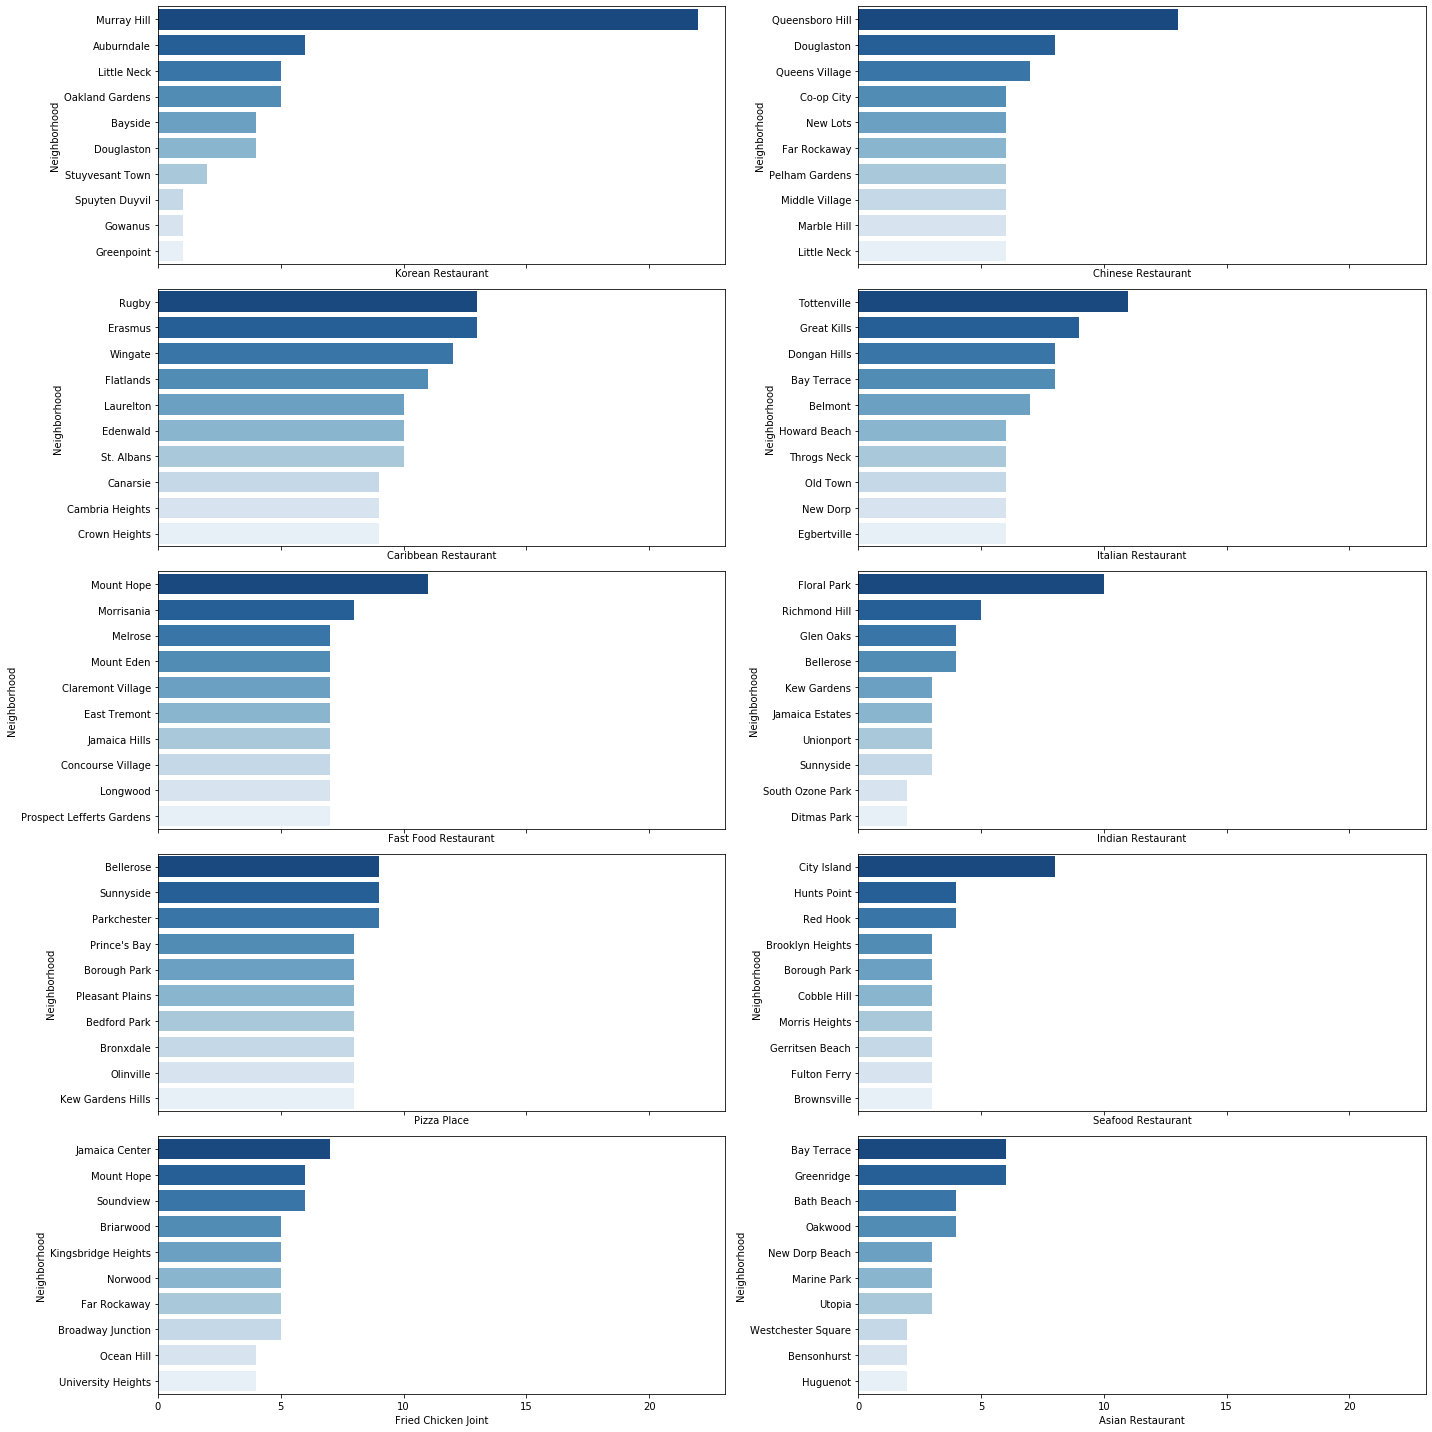

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Beer Store,Bike Shop,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hobby Shop,Indian Chinese Restaurant,Indian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Record Shop,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.227273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136364,0.0,0.0,0.0,0.136364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.227273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.105263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.111111,0.0,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.277778,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [44]:
# Let's confirm the new size
nyc_grouped.shape

(302, 99)

##### Let's write a function to sort the venues in descending order

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
# Now let's create the new dataframe and display the top 5 venues for each neighborhood.
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant
3,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant


#### Cluster Neighborhoods
Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [47]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

##### Determining the optimal number of clusters for k-means clustering
We will use the Elbow Method to calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [48]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

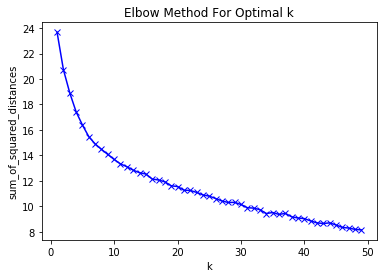

In [50]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

The elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

Let's try the Silhouette Method. The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 

In [ ]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at k = 2, k = 4 and k = 8. Two and four clusters will give a very broad classification of the venues.

##### Let's set number of clusters = 8

In [62]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({1: 63, 2: 59, 5: 54, 0: 44, 7: 34, 4: 24, 3: 23, 6: 1})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [63]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,5,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
2,1,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant
3,1,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant
4,7,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant


In [64]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,5,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
1,1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,1,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Staten Island,40.549286,-74.185887
3,1,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant,Staten Island,40.635325,-74.165104
4,7,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124


In [66]:
# Finally, let's visualize the resulting clusters


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 5. Results

In [67]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

##### Cluster 0

In [68]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
30,Briarwood,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Latin American Restaurant,Queens,40.710935,-73.811748
33,Broadway Junction,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Brooklyn,40.677861,-73.903317
47,Central Harlem,Pizza Place,Fast Food Restaurant,Southern / Soul Food Restaurant,American Restaurant,Fried Chicken Joint,Manhattan,40.815976,-73.943211
52,City Line,Fast Food Restaurant,Pizza Place,Latin American Restaurant,Chinese Restaurant,Fried Chicken Joint,Brooklyn,40.678570,-73.867976
54,Claremont Village,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Seafood Restaurant,Mexican Restaurant,Bronx,40.831428,-73.901199


In [73]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("____________________________________________")

Fast Food Restaurant               30
Pizza Place                         6
Fried Chicken Joint                 3
Mexican Restaurant                  2
Chinese Restaurant                  1
Southern / Soul Food Restaurant     1
Spanish Restaurant                  1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Pizza Place                  11
Fast Food Restaurant         10
Chinese Restaurant            5
Mexican Restaurant            4
Fried Chicken Joint           4
Latin American Restaurant     3
American Restaurant           2
Italian Restaurant            1
Middle Eastern Restaurant     1
Caribbean Restaurant          1
Thai Restaurant               1
Steakhouse                    1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Bronx            22
Brooklyn          9
Queens            7
Manhattan         5
Staten Island     1
Name: Borough, dtype: int64
____________________________________________


##### Cluster 1

In [74]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Staten Island,40.549286,-74.185887
3,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant,Staten Island,40.635325,-74.165104
6,Astoria,Pizza Place,Greek Restaurant,Italian Restaurant,Fast Food Restaurant,Thai Restaurant,Queens,40.768509,-73.915654
16,Bedford Park,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,Bronx,40.870185,-73.885512


In [75]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("____________________________________________")

Pizza Place            61
Asian Restaurant        1
American Restaurant     1
Taco Place              1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Chinese Restaurant             15
American Restaurant            12
Italian Restaurant             10
Fast Food Restaurant            4
Pizza Place                     3
Indian Restaurant               3
Thai Restaurant                 2
Mexican Restaurant              2
Greek Restaurant                2
Seafood Restaurant              2
Sushi Restaurant                2
BBQ Joint                       2
Eastern European Restaurant     1
Sri Lankan Restaurant           1
Caribbean Restaurant            1
Latin American Restaurant       1
Spanish Restaurant              1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Staten Island    27
Queens           15
Brooklyn         13
Bronx             8
Manhattan         1
Name: Borough, dtype: int64
________________

##### Cluster 2

In [77]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
8,Auburndale,Korean Restaurant,Pizza Place,Greek Restaurant,Chinese Restaurant,Italian Restaurant,Queens,40.761730,-73.791762
11,Bay Ridge,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Mexican Restaurant,Yemeni Restaurant,Brooklyn,40.625801,-74.030621
14,Bayside,Korean Restaurant,Greek Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Queens,40.766041,-73.774274
17,Bedford Stuyvesant,Caribbean Restaurant,Fried Chicken Joint,French Restaurant,Southern / Soul Food Restaurant,Pizza Place,Brooklyn,40.687232,-73.941785
25,Blissville,Pizza Place,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Queens,40.737251,-73.932442


In [78]:

for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("____________________________________________")

Pizza Place                    32
Mexican Restaurant             12
Korean Restaurant               4
Sushi Restaurant                2
Thai Restaurant                 2
Indian Restaurant               2
American Restaurant             1
Taco Place                      1
Vietnamese Restaurant           1
Fast Food Restaurant            1
Caribbean Restaurant            1
Eastern European Restaurant     1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Mexican Restaurant           14
Fast Food Restaurant          7
Pizza Place                   7
Italian Restaurant            5
American Restaurant           4
Fried Chicken Joint           3
BBQ Joint                     2
Russian Restaurant            2
Latin American Restaurant     2
New American Restaurant       2
Chinese Restaurant            2
Sushi Restaurant              1
French Restaurant             1
Asian Restaurant              1
Greek Restaurant              1
Japanese Restaurant      

##### Cluster 3

In [79]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
36,Brookville,Caribbean Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
41,Cambria Heights,Caribbean Restaurant,Chinese Restaurant,African Restaurant,Pizza Place,Latin American Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Brooklyn,40.635564,-73.902093
68,Crown Heights,Caribbean Restaurant,Chinese Restaurant,Mexican Restaurant,Thai Restaurant,Fast Food Restaurant,Brooklyn,40.670829,-73.943291
77,East Flatbush,Caribbean Restaurant,Chinese Restaurant,Fried Chicken Joint,Fast Food Restaurant,American Restaurant,Brooklyn,40.641718,-73.936103


In [80]:

for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("____________________________________________")

Caribbean Restaurant    21
Fast Food Restaurant     1
American Restaurant      1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Chinese Restaurant      8
Pizza Place             6
Fast Food Restaurant    4
Fried Chicken Joint     4
Caribbean Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Brooklyn         10
Queens            8
Bronx             4
Staten Island     1
Name: Borough, dtype: int64
____________________________________________


##### Cluster 4

In [81]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
10,Battery Park City,Fast Food Restaurant,Seafood Restaurant,Mediterranean Restaurant,Italian Restaurant,American Restaurant,Manhattan,40.711932,-74.016869
24,Bergen Beach,Sushi Restaurant,American Restaurant,Pizza Place,Middle Eastern Restaurant,Moroccan Restaurant,Brooklyn,40.615150,-73.898556
27,Boerum Hill,Pizza Place,New American Restaurant,Italian Restaurant,Seafood Restaurant,Cuban Restaurant,Brooklyn,40.685683,-73.983748
44,Carroll Gardens,Pizza Place,Italian Restaurant,Seafood Restaurant,French Restaurant,Ramen Restaurant,Brooklyn,40.680540,-73.994654
45,Castle Hill,Spanish Restaurant,American Restaurant,Pizza Place,Latin American Restaurant,Fried Chicken Joint,Bronx,40.819014,-73.848027


In [82]:

for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("____________________________________________")

American Restaurant        7
Pizza Place                6
Italian Restaurant         5
Seafood Restaurant         3
Fast Food Restaurant       1
New American Restaurant    1
Sushi Restaurant           1
Spanish Restaurant         1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
American Restaurant        8
Italian Restaurant         6
Pizza Place                5
Seafood Restaurant         3
Mexican Restaurant         1
New American Restaurant    1
Spanish Restaurant         1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Brooklyn         9
Manhattan        6
Bronx            5
Staten Island    3
Queens           2
Name: Borough, dtype: int64
____________________________________________


##### Cluster 5

In [83]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
5,Arverne,Pizza Place,Chinese Restaurant,American Restaurant,Asian Restaurant,Thai Restaurant,Queens,40.589144,-73.791992
7,Astoria Heights,Greek Restaurant,Pizza Place,Chinese Restaurant,Italian Restaurant,Indian Restaurant,Queens,40.770317,-73.894680
9,Bath Beach,Vietnamese Restaurant,Cantonese Restaurant,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Brooklyn,40.599519,-73.998752
13,Baychester,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Pizza Place,Spanish Restaurant,Bronx,40.866858,-73.835798


In [84]:

for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("____________________________________________")

Chinese Restaurant       27
Pizza Place              19
Caribbean Restaurant      2
Sushi Restaurant          2
Fried Chicken Joint       1
Greek Restaurant          1
American Restaurant       1
Vietnamese Restaurant     1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Chinese Restaurant       18
Pizza Place              12
Fast Food Restaurant      4
Italian Restaurant        4
Fried Chicken Joint       4
Korean Restaurant         3
Cantonese Restaurant      2
Japanese Restaurant       1
Mexican Restaurant        1
Vietnamese Restaurant     1
Greek Restaurant          1
American Restaurant       1
Russian Restaurant        1
Taco Place                1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Queens           23
Brooklyn         11
Bronx             8
Staten Island     7
Manhattan         5
Name: Borough, dtype: int64
____________________________________________


##### Cluster 6

In [85]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
152,Lighthouse Hill,Italian Restaurant,Yemeni Restaurant,Greek Restaurant,Empanada Restaurant,English Restaurant,Staten Island,40.576506,-74.137927


In [86]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("____________________________________________")

Italian Restaurant    1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Yemeni Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Staten Island    1
Name: Borough, dtype: int64
____________________________________________


##### Cluster 7

In [87]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Staten Island,40.553988,-74.139166
20,Belle Harbor,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,BBQ Joint,Chinese Restaurant,Queens,40.576156,-73.854018
22,Belmont,Italian Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Chinese Restaurant,Bronx,40.857277,-73.888452


In [88]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("____________________________________________")

Italian Restaurant    29
Pizza Place            4
Asian Restaurant       1
Seafood Restaurant     1
Name: 1st Most Common Venue, dtype: int64
____________________________________________
Pizza Place             15
Italian Restaurant       6
Mexican Restaurant       4
Fast Food Restaurant     3
Chinese Restaurant       2
Asian Restaurant         2
Turkish Restaurant       1
Japanese Restaurant      1
American Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
____________________________________________
Staten Island    17
Queens           10
Brooklyn          3
Bronx             3
Manhattan         2
Name: Borough, dtype: int64
____________________________________________


##### The End. Thank You!